In [ ]:
# imports
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from tqdm import tqdm
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

Read in the data

In [ ]:
# read in tweets from file
# store tweets in a list
# tweets are in txt file, one tweet per line


def read_tweets(file_name):
    tweets = []
    with open(file_name, 'r') as f:
        for line in f:
            tweets.append(line.strip())
    return tweets

english_tweets = read_tweets("/Users/fordshaper/Desktop/MLTA/ECON1680_proj2/data/2021_en_fl.txt")
spanish_tweets = read_tweets("/Users/fordshaper/Desktop/MLTA/ECON1680_proj2/data/2021_es_fl.txt")

# print length of each list
print("Number of English tweets:", len(english_tweets))
print("Number of Spanish tweets:", len(spanish_tweets))


Number of English tweets: 38474
Number of Spanish tweets: 40753


In [ ]:
def preprocess_tweets(tweets, language):
    stop_words = set(stopwords.words(language))
    cleaned_tweets = []
    for tweet in tweets:
        tweet = tweet.lower()  # convert to lowercase
        tweet = re.sub(r'http\S+|www\S+|https\S+|URL+|url+', '', tweet, flags=re.MULTILINE)  # remove URLs
        tweet = re.sub(r'\@\w+|\#', '', tweet)  # remove mentions and hashtags
        tweet = re.sub(r'\W', ' ', tweet)  # remove non-alphabetic characters
        tweet = re.sub(r'\s+', ' ', tweet).strip()  # remove extra spaces
        # Tokenization and stopword removal
        tweet_tokens = word_tokenize(tweet)
        filtered_words = [word for word in tweet_tokens if word not in stop_words]
        cleaned_tweets.append(' '.join(filtered_words))
    return cleaned_tweets

cleaned_english_tweets = preprocess_tweets(english_tweets, 'english')
cleaned_spanish_tweets = preprocess_tweets(spanish_tweets, 'spanish')

Now we can focus on doing some visualization of our data

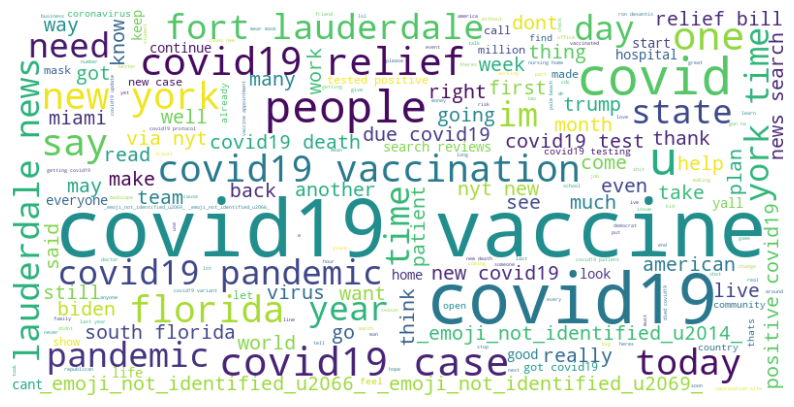

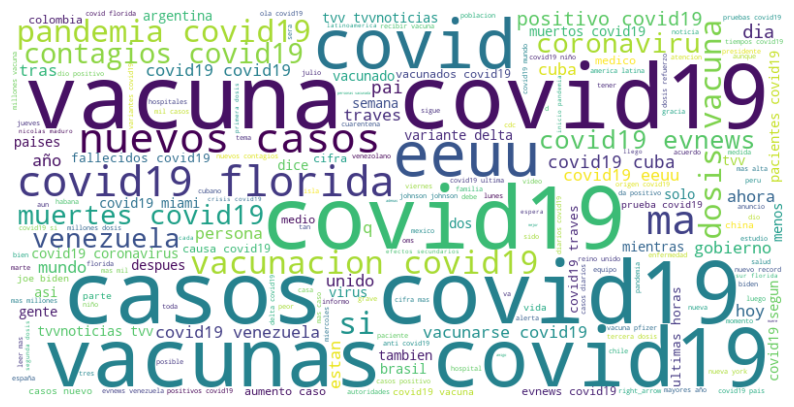

In [ ]:
def generate_word_cloud(tweets):
    all_words = ' '.join(tweets)
    word_cloud = WordCloud(width=800, height=400, background_color ='white', max_words=200).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_word_cloud(cleaned_english_tweets)
generate_word_cloud(cleaned_spanish_tweets)

# save the word clouds as images
word_cloud = WordCloud(width=800, height=400, background_color ='white', max_words=200).generate(' '.join(cleaned_english_tweets))
word_cloud.to_file('visuals/english_word_cloud.png')
word_cloud = WordCloud(width=800, height=400, background_color ='white', max_words=200).generate(' '.join(cleaned_spanish_tweets))
word_cloud.to_file('visuals/spanish_word_cloud.png')

Now we can do some sentiment analysis

In [ ]:
model_path = f"lxyuan/distilbert-base-multilingual-cased-sentiments-student" # set the model path
sentiment_task = pipeline("sentiment-analysis", model=model_path)

def get_sentiment(tweets):
    sentiments = []
    for tweet in tweets:
        sentiment = sentiment_task(tweet)[0]
        sentiments.append(sentiment)
    return sentiments

# get sentiment of first 5 tweets
english_sentiments = get_sentiment(cleaned_english_tweets[:5])
spanish_sentiments = get_sentiment(cleaned_spanish_tweets[:5])

print("English Sentiments:", english_sentiments)
print("Spanish Sentiments:", spanish_sentiments)

def batch_analyze_sentiments(tweets, batch_size=64):
    sentiments = []
    # Wrap the range function with tqdm for a progress bar
    for i in tqdm(range(0, len(tweets), batch_size), desc="Analyzing Sentiments"):
        batch = tweets[i:i+batch_size]
        batch_sentiments = sentiment_task(batch)
        sentiments.extend(batch_sentiments)
    return sentiments


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


English Sentiments: [{'label': 'negative', 'score': 0.7343556880950928}, {'label': 'negative', 'score': 0.6926671266555786}, {'label': 'positive', 'score': 0.4535945951938629}, {'label': 'positive', 'score': 0.4224318563938141}, {'label': 'positive', 'score': 0.6388757824897766}]
Spanish Sentiments: [{'label': 'positive', 'score': 0.7874047160148621}, {'label': 'negative', 'score': 0.4742232859134674}, {'label': 'positive', 'score': 0.43165671825408936}, {'label': 'negative', 'score': 0.8473516702651978}, {'label': 'negative', 'score': 0.4289802312850952}]


In [ ]:
# trying a different model
# Set the model path
# model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"

# # Load the tokenizer and model manually
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# # Ensure from_pt=True to convert PyTorch weights for TensorFlow
# model = AutoModelForSequenceClassification.from_pretrained(model_path, from_pt=True)

# # Create the sentiment analysis pipeline with the manually loaded model and tokenizer
# sentiment_task = pipeline("text-classification", model=model, tokenizer=tokenizer)

# def batch_analyze_sentiments(tweets, batch_size=364):
#     sentiments = []
#     # Wrap the range function with tqdm for a progress bar
#     for i in tqdm(range(0, len(tweets), batch_size), desc="Analyzing Sentiments"):
#         batch = tweets[i:i+batch_size]
#         batch_sentiments = sentiment_task(batch)
#         sentiments.extend(batch_sentiments)
#     return sentiments

# can't actually run this rn because the model depends on pytorch and I'm using tensorflow
# may try to work out an environment where I can run this later

In [ ]:
# sentiment analysis of all tweets
english_sentiments = batch_analyze_sentiments(cleaned_english_tweets)
spanish_sentiments = batch_analyze_sentiments(cleaned_spanish_tweets)

Analyzing Sentiments: 100%|██████████| 637/637 [54:43<00:00,  5.15s/it]   


In [ ]:
# save the sentiment results to a csv file
def save_sentiments(sentiments, file_name):
    with open(file_name, 'w') as f:
        for sentiment in sentiments:
            f.write(f"{sentiment['label']},{sentiment['score']}\n")

save_sentiments(english_sentiments, "data/english_sentiments.csv")
save_sentiments(spanish_sentiments, "data/spanish_sentiments.csv")

In [ ]:
# read the sentiment results from the csv file
def read_sentiments(file_name):
    sentiments = []
    with open(file_name, 'r') as f:
        for line in f:
            label, score = line.strip().split(',')
            sentiments.append({'label': label, 'score': float(score)})
    return sentiments

english_sentiments = read_sentiments("data/english_sentiments.csv")
spanish_sentiments = read_sentiments("data/spanish_sentiments.csv")


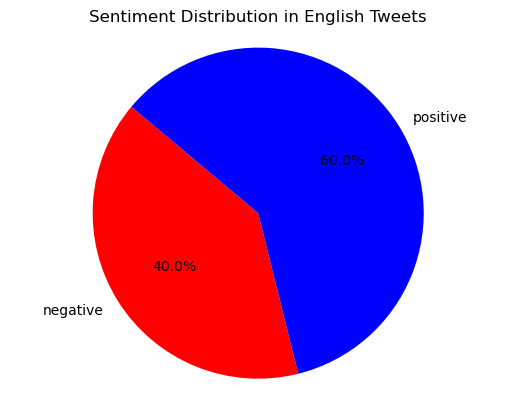

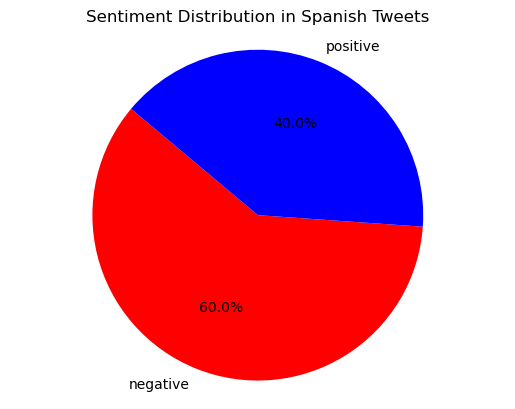

In [ ]:
# we can also try to plot the sentiment distribution as a pie chart
def plot_sentiment_pie_chart(sentiments, language):
    labels = [s['label'] for s in sentiments]
    counts = dict((x,labels.count(x)) for x in set(labels))
    # positve blue, negative red, neutral yellow
    colors = [ 'red', 'blue']
    plt.pie(counts.values(), labels=counts.keys(), colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(f'Sentiment Distribution in {language} Tweets')
    # save the plot as an image
    plt.savefig(f'visuals/{language}_sentiment_pie_chart.png')
    plt.show()

plot_sentiment_pie_chart(english_sentiments, 'English')
plot_sentiment_pie_chart(spanish_sentiments, 'Spanish')

In [ ]:
def tokenize_tweets(tweets):
    tokenized_tweets = []
    for tweet in tweets:
        tokenized_tweets.append(word_tokenize(tweet))
    tokenized_tweets = [token for token in tokenized_tweets if len(token) > 2]
    return tokenized_tweets

english_tokenized_tweets = tokenize_tweets(cleaned_english_tweets)
spanish_tokenized_tweets = tokenize_tweets(cleaned_spanish_tweets)

# Create a dictionary representation of the documents
english_dictionary = Dictionary(english_tokenized_tweets)
spanish_dictionary = Dictionary(spanish_tokenized_tweets)

# Filter out extremes to remove tokens that appear too frequently or too rarely
english_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
spanish_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Convert document into the bag-of-words (BoW) format = list of (token_id, token_count)
english_corpus = [english_dictionary.doc2bow(tweet) for tweet in english_tokenized_tweets]
spanish_corpus = [spanish_dictionary.doc2bow(tweet) for tweet in spanish_tokenized_tweets]



In [ ]:
"""function to train an LDA model. The function should take the corpus, dictionary, number of topics, number of passes, and evaluation frequency as input arguments. 
The function should return the trained LDA model. No evaluation because it takes too long and is not necessary for this project."""
def train_lda_model(corpus, dictionary, num_topics=5, passes=10, eval_every=None):
    # Make a index to word dictionary
    temp = dictionary[0]  # This is only to "load" the dictionary
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=1000,
        alpha='auto',
        eta='auto',
        iterations=400,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )
    
    return model

# Train LDA model on English tweets
english_lda_model = train_lda_model(english_corpus, english_dictionary)

# Train LDA model on Spanish tweets
spanish_lda_model = train_lda_model(spanish_corpus, spanish_dictionary)


In [ ]:
# now let's visualize the topics
def visualize_topics(lda_model, dictionary, num_topics=5):
    for i in range(num_topics):
        print(f"Topic {i+1}: {lda_model.print_topic(i)}")
        print()

# Visualize topics for English tweets
visualize_topics(english_lda_model, english_dictionary)

# Visualize topics for Spanish tweets
visualize_topics(spanish_lda_model, spanish_dictionary)

Topic 1: 0.028*"covid" + 0.023*"people" + 0.017*"year" + 0.014*"us" + 0.013*"im" + 0.012*"like" + 0.012*"one" + 0.010*"dont" + 0.010*"positive" + 0.010*"trump"

Topic 2: 0.094*"new" + 0.060*"florida" + 0.043*"cases" + 0.027*"_emoji_not_identified_u2066_" + 0.026*"_emoji_not_identified_u2069_" + 0.024*"deaths" + 0.022*"coronavirus" + 0.016*"county" + 0.014*"miamidade" + 0.013*"times"

Topic 3: 0.053*"vaccine" + 0.031*"get" + 0.015*"vaccines" + 0.014*"got" + 0.013*"first" + 0.012*"miami" + 0.011*"getting" + 0.010*"vaccination" + 0.009*"variant" + 0.009*"says"

Topic 4: 0.021*"pandemic" + 0.021*"2020" + 0.020*"2021" + 0.013*"help" + 0.011*"see" + 0.008*"work" + 0.008*"na" + 0.008*"relief" + 0.008*"biden" + 0.007*"ever"

Topic 5: 0.032*"health" + 0.014*"could" + 0.013*"care" + 0.013*"mask" + 0.012*"spread" + 0.010*"great" + 0.009*"travel" + 0.009*"cdc" + 0.008*"public" + 0.008*"dr"

Topic 1: 0.094*"casos" + 0.045*"cuba" + 0.043*"muertes" + 0.043*"contagios" + 0.040*"nuevos" + 0.022*"nuevo"

In [ ]:
# manually creating some topics based on words in above topics and intuition
english_topics = {
    'politics': ['government', 'president', 'country', 'people', 'election'],
    'democrats': ['democrats', 'biden', 'president', 'administration', 'kamala'],
    'republicans': ['republicans', 'trump', 'desantis', 'gop'],
    'health': ['covid', 'pandemic', 'health', 'virus'],
    'healthcare': ['healthcare', 'insurance', 'medicare', 'medicaid'],
    'medicine': ['medicine', 'doctor', 'hospital', 'treatment', 'cure', 'mask', 'face mask', 'ppe'],
    'vaccines': ['vaccine', 'dose', 'vaccination', 'pfizer', 'dose'
                'vaccination', 'pfizer', 'moderna', 'astrazeneca', 'johnson', 'janssen'],
    'latin_america': ['mexico', 'brazil', 'argentina', 'chile', 'peru', 'colombia', 'venezuela', 'bolivia', 'ecuador', 'latin america', 'latino', 'hispanic']
}

spanish_topics = {
    'politics': ['gobierno', 'presidente', 'país', 'personas', 'elección'],
    'democrats': ['demócratas', 'biden', 'presidente', 'administración', 'kamala'],
    'republicans': ['republicanos', 'trump', 'desantis', 'gop'],
    'health': ['covid', 'pandemia', 'salud', 'virus'],
    'healthcare': ['atención médica', 'seguro', 'medicare', 'medicaid', 'hospital'],
    'medicine': ['medicina', 'doctor', 'hospital', 'tratamiento', 'cura', 'máscara', 'mascarilla', 'ppe'],
    'vaccines': ['vacuna', 'dosis', 'vacunación', 'pfizer', 'moderna', 'astrazeneca', 'johnson', 'janssen'],
    'latin_america': ['mexico', 'brasil', 'argentina', 'chile', 'peru', 'colombia', 'venezuela', 'bolivia', 'ecuador', 'latinoamerica', 'latino', 'hispano']
}

In [ ]:
"""the function should take the tweets and categories as input arguments and return a dictionary 
where the keys are the categories and the values are lists of indexes of tweets that belong to that category."""
def categorize_tweets(tweets, categories, sentiments):
    categorized_tweets_indexes = {category: [] for category in categories.keys()}
    for index, tweet in enumerate(tweets):
        for category, keywords in categories.items():
            if any(keyword.lower() in tweet.lower() for keyword in keywords):
                # Append the index of the tweet to the corresponding category as well as the sentiment
                # sentiments is a list of dictionaries with keys 'label' and 'score' for each tweet where label is the "POSITIVE" or "NEGATIVE" and score is the confidence
                categorized_tweets_indexes[category].append((index, sentiments[index]))
                break  # Assuming each tweet fits into one category best, remove this if a tweet can fit into multiple categories
    return categorized_tweets_indexes

# Categorize English tweets
english_categorized_tweets = categorize_tweets(english_tweets, english_topics, english_sentiments)

# Categorize Spanish tweets
spanish_categorized_tweets = categorize_tweets(spanish_tweets, spanish_topics, spanish_sentiments)

# print the number of tweets in each category
for category, indexes in english_categorized_tweets.items():
    print(f"Number of English tweets in {category} category:", len(indexes))

for category, indexes in spanish_categorized_tweets.items():
    print(f"Number of Spanish tweets in {category} category:", len(indexes))


Number of English tweets in politics category: 3924
Number of English tweets in democrats category: 1294
Number of English tweets in republicans category: 1267
Number of English tweets in health category: 29465
Number of English tweets in healthcare category: 12
Number of English tweets in medicine category: 212
Number of English tweets in vaccines category: 549
Number of English tweets in latin_america category: 30
Number of Spanish tweets in politics category: 3174
Number of Spanish tweets in democrats category: 615
Number of Spanish tweets in republicans category: 412
Number of Spanish tweets in health category: 34393
Number of Spanish tweets in healthcare category: 87
Number of Spanish tweets in medicine category: 67
Number of Spanish tweets in vaccines category: 607
Number of Spanish tweets in latin_america category: 133


politics: 1348 positive, 2564 negative out of 3924 total tweets
democrats: 627 positive, 656 negative out of 1294 total tweets
republicans: 286 positive, 979 negative out of 1267 total tweets
health: 15558 positive, 13742 negative out of 29465 total tweets
healthcare: 8 positive, 4 negative out of 12 total tweets
medicine: 90 positive, 119 negative out of 212 total tweets
vaccines: 257 positive, 290 negative out of 549 total tweets
latin_america: 13 positive, 17 negative out of 30 total tweets
politics: 860 positive, 2313 negative out of 3174 total tweets
democrats: 262 positive, 353 negative out of 615 total tweets
republicans: 110 positive, 302 negative out of 412 total tweets
health: 14682 positive, 19665 negative out of 34393 total tweets
healthcare: 40 positive, 47 negative out of 87 total tweets
medicine: 29 positive, 38 negative out of 67 total tweets
vaccines: 179 positive, 426 negative out of 607 total tweets
latin_america: 51 positive, 82 negative out of 133 total tweets


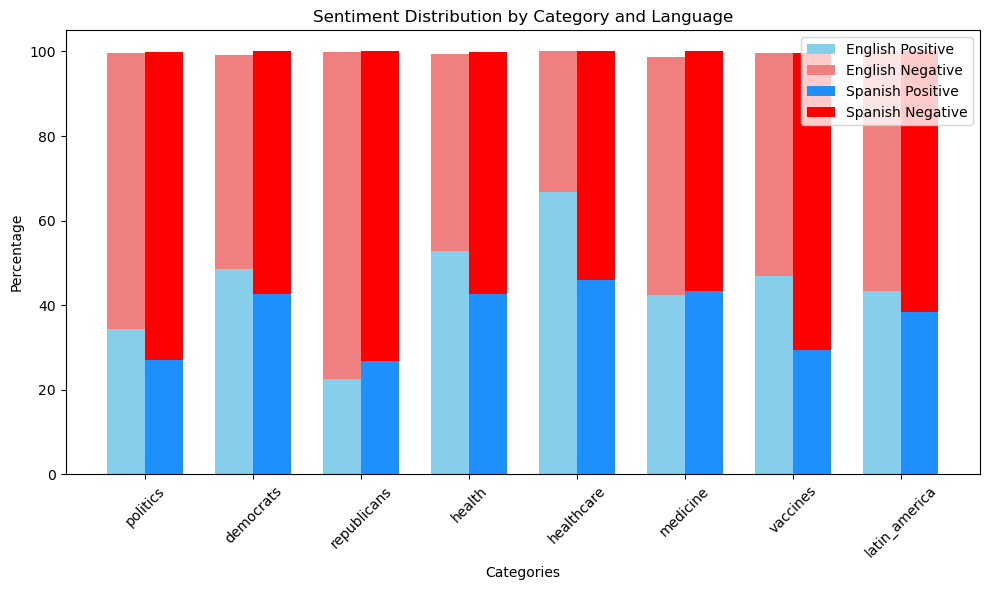

In [ ]:
# function to analyze the sentiment distribution of categorized tweets
def analyze_sentiment_distribution(categorized_tweets):
    for category, tweets in categorized_tweets.items():
        positive = sum(1 for _, sentiment in tweets if sentiment['label'] == 'positive')
        negative = sum(1 for _, sentiment in tweets if sentiment['label'] == 'negative')
        total = len(tweets)
        print(f"{category}: {positive} positive, {negative} negative out of {total} total tweets")

analyze_sentiment_distribution(english_categorized_tweets)
analyze_sentiment_distribution(spanish_categorized_tweets)

def get_category_sentiments(categorized_tweets):
    category_sentiments = {}
    for category in categorized_tweets.keys():
        tweets = categorized_tweets[category]
        positive = sum(1 for _, sentiment in tweets if sentiment['label'] == 'positive')
        negative = sum(1 for _, sentiment in tweets if sentiment['label'] == 'negative')
        total = len(tweets)
        positive_percentage = positive / total * 100
        negative_percentage = negative / total * 100
        category_sentiments[category] = {'positive': positive_percentage, 'negative': negative_percentage}
    return category_sentiments

# function to plot percentage of positive and negative tweets in each category
def plot_sentiment_distribution(en_categorized_tweets, es_categorized_tweets):
    # categorized tweets is a dictionary where keys are categories and values are lists of tuples (index, sentiment)
    en_category_sentiments = get_category_sentiments(en_categorized_tweets)
    es_category_sentiments = get_category_sentiments(es_categorized_tweets)
    # Plot the sentiment distribution for each category
    plt.figure(figsize=(10, 6))
    # use only the labels from english categories, the order of the labels will be the same for both languages
    labels = list(en_category_sentiments.keys())
    bar_width = 0.35
    index = range(len(labels))

    # Plotting English sentiments
    plt.bar(index,
            [en_category_sentiments[category]['positive'] for category in labels],
            bar_width,
            label='English Positive',
            color='skyblue')

    plt.bar(index,
            [en_category_sentiments[category]['negative'] for category in labels],
            bar_width,
            bottom=[en_category_sentiments[category]['positive'] for category in labels],
            label='English Negative',
            color='lightcoral')

    # Plotting Spanish sentiments
    plt.bar([i + bar_width for i in index],
            [es_category_sentiments[category]['positive'] for category in labels],
            bar_width,
            label='Spanish Positive',
            color='dodgerblue')

    plt.bar([i + bar_width for i in index],
            [es_category_sentiments[category]['negative'] for category in labels],
            bar_width,
            bottom=[es_category_sentiments[category]['positive'] for category in labels],
            label='Spanish Negative',
            color='red')

    plt.xlabel('Categories')
    plt.ylabel('Percentage')
    plt.title('Sentiment Distribution by Category and Language')
    plt.xticks([i + bar_width/2 for i in index], labels, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('visuals/sentiment_distribution.png')
    plt.show()
    # save the plot as an image


plot_sentiment_distribution(english_categorized_tweets, spanish_categorized_tweets)